# Generating spike trains from a synthetic connectome

In this notebook, we generate spiketrains from a recurrent E-I network with current-based LIF neurons, and assembly connectivity inspired by zebrafish Dp.

### Overview
1. First we generate a biologically plausible recurrent weight matrix with a Dp-inspired assembly structure.
2. Next we generate excitatory mitral cell inputs from the OB with Poisson stastics and sparse projections.
3. Then we initialise our network with parameters adapted from [Meissner-Bernard et al. (2025)](https://doi.org/10.1016/j.celrep.2025.115330).
4. Finally we run our network and examine the output dynamics.

In [1]:
# | code-fold: true
# | code-summary: "Setup autoreload"
# | output: false
%load_ext autoreload
%autoreload 2
%xmode Verbose

Exception reporting mode: Verbose


In [2]:
# | code-fold: true
# | code-summary: "Import libraries"
import matplotlib.pyplot as plt
import numpy as np
import toml
from pathlib import Path
from synthetic_connectome import topology_generators, weight_assigners, cell_types
from network_simulators.current_lif_network import CurrentLIFNetwork
from visualization import plot_membrane_voltages, plot_synaptic_currents
import torch

repo_root = Path().resolve().parent

In [3]:
# | code-fold: true
# | code-summary: "Select device (CPU/GPU)"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Load all network parameters

We first load all parameters from a TOML file that specifies network topology, synaptic weight distributions, feedforward input configuration, and neuron physiology parameters.

In [4]:
# Load network parameters from TOML file
params_file = repo_root / "parameters" / "current-based-Dp.toml"
with open(params_file, "r") as f:
    params = toml.load(f)

In [5]:
# | code-fold: true
# | code-summary: "Extract parameters from TOML"
# Extract and convert all parameters at the top
dt = float(params["simulation"]["dt"])
duration = float(params["simulation"]["duration"])
seed = params["simulation"].get("seed", None)

num_neurons = int(params["connectome"]["topology"]["num_neurons"])
num_assemblies = int(params["connectome"]["topology"]["num_assemblies"])
conn_within = np.array(params["connectome"]["topology"]["conn_within"])
conn_between = np.array(params["connectome"]["topology"]["conn_between"])

cell_type_names = params["connectome"]["cell_types"]["names"]
cell_type_signs = np.array(params["connectome"]["cell_types"]["signs"], dtype=int)
cell_type_proportions = np.array(
    params["connectome"]["cell_types"]["proportion"], dtype=float
)

w_mu = np.array(params["connectome"]["weights"]["w_mu"], dtype=float)
w_sigma = np.array(params["connectome"]["weights"]["w_sigma"], dtype=float)

input_num_neurons = int(params["inputs"]["topology"]["num_neurons"])
input_cell_type_names = params["inputs"]["cell_types"]["names"]
input_firing_rates = np.array(params["inputs"]["activity"]["firing_rates"], dtype=float)
input_conn_inputs = np.array(params["inputs"]["topology"]["conn_inputs"], dtype=float)
input_w_mu = np.array(params["inputs"]["weights"]["w_mu"], dtype=float)
input_w_sigma = np.array(params["inputs"]["weights"]["w_sigma"], dtype=float)

# Correctly structure physiology_params as a nested dictionary
physiology_params = {
    ct: {
        "tau_mem": float(params["physiology"][ct]["tau_mem"]),
        "tau_syn": float(params["physiology"][ct]["tau_syn"]),
        "R": float(params["physiology"][ct]["R"]),
        "U_rest": float(params["physiology"][ct]["U_rest"]),
        "theta": float(params["physiology"][ct]["theta"]),
        "U_reset": float(params["physiology"][ct]["U_reset"]),
    }
    for ct in cell_type_names
}

# Correctly structure physiology_params_FF as a nested dictionary
physiology_params_FF = {
    ct: {
        "tau_syn": float(params["inputs"]["physiology"][ct]["tau_syn"]),
    }
    for ct in input_cell_type_names
}

scaling_factors = np.array(params["optimisation"]["scaling_factors"], dtype=float)
scaling_factors_FF = np.array(params["optimisation"]["scaling_factors_FF"], dtype=float)

surrgrad_scale = float(params["hyperparameters"]["surrgrad_scale"])

# Set global random seed for reproducibility (only if specified in config)
if seed is not None:
    np.random.seed(seed)
    print(f"Using seed: {seed}")
else:
    print("No seed specified - using random initialization")

Using seed: 42


In [6]:
# | code-fold: true
# | code-summary: "Display parameter details"
# Display simulation parameters
print("Simulation Parameters")
print("=" * 22)
print(f"Duration: {duration} ms")
print(f"Time step: {dt} ms")
print(f"Seed: {seed}")

# Display cell type information
print("\nCell Types")
print("=" * 10)
for i, name in enumerate(cell_type_names):
    sign_str = "Excitatory" if cell_type_signs[i] == 1 else "Inhibitory"
    print(f"{name}: {sign_str}, Proportion: {cell_type_proportions[i]}")

# Display topology parameters
print("\nNetwork Topology Parameters")
print("=" * 26)
print(f"Neurons: {num_neurons}")
print(f"Assemblies: {num_assemblies}")
print(f"Connection prob. within assemblies:\n{conn_within}")
print(f"Connection prob. between assemblies:\n{conn_between}")

# Display synaptic weight parameters
print("\nSynaptic Weight Parameters")
print("=" * 24)
print(f"Weight means (log space):\n{w_mu}")
print(f"Weight standard deviations (log space):\n{w_sigma}")

# Display input parameters
print("\nInput Parameters")
print("=" * 16)
print(f"Input neurons: {input_num_neurons}")
print(f"Input firing rates: {input_firing_rates} Hz")
print(f"Input connection probabilities:\n{input_conn_inputs}")

# Display physiology parameters
print("\nPhysiology Parameters")
print("=" * 21)
for cell_type, params_dict in physiology_params.items():
    print(f"\n{cell_type.capitalize()} Neurons:")
    for param, value in params_dict.items():
        print(f"  {param}: {value}")

Simulation Parameters
Duration: 10000.0 ms
Time step: 1.0 ms
Seed: 42

Cell Types
excitatory: Excitatory, Proportion: 0.8
inhibitory: Inhibitory, Proportion: 0.2

Network Topology Parameters
Neurons: 5000
Assemblies: 20
Connection prob. within assemblies:
[[0.05 0.05]
 [0.3  0.05]]
Connection prob. between assemblies:
[[0.01 0.01]
 [0.01 0.01]]

Synaptic Weight Parameters
Weight means (log space):
[[1.  1.2]
 [2.4 1.6]]
Weight standard deviations (log space):
[[0.8 0.8]
 [0.2 0.2]]

Input Parameters
Input neurons: 1500
Input firing rates: [6.] Hz
Input connection probabilities:
[[0.02 0.  ]]

Physiology Parameters

Excitatory Neurons:
  tau_mem: 85.0
  tau_syn: 30.0
  R: 740.74
  U_rest: -60.0
  theta: -38.0
  U_reset: -60.0

Inhibitory Neurons:
  tau_mem: 50.0
  tau_syn: 10.0
  R: 1111.11
  U_rest: -60.0
  theta: -45.0
  U_reset: -60.0


### Generate Assembly-Based Topology

We now create an unweighted network with assembly-based connectivity structure. This is a matrix indicating inhibitory/excitatory connections.

We then visualise this graph. Note that the assembly structure is not obvious because by design our matrix is shuffled.

In [7]:
# | code-fold: true
# | code-summary: "Display topology parameters"
# Display network topology parameters
print("Network Topology Parameters")
print("=" * 26)
print(f"Neurons: {num_neurons}")
print(f"Assemblies: {num_assemblies}")
print("\nConnection probabilities within assemblies:")
for i, row in enumerate(conn_within):
    from_type = cell_type_names[i]
    for j, prob in enumerate(row):
        to_type = cell_type_names[j]
        print(f"  {from_type} → {to_type}: {prob}")

print("\nConnection probabilities between assemblies:")
for i, row in enumerate(conn_between):
    from_type = cell_type_names[i]
    for j, prob in enumerate(row):
        to_type = cell_type_names[j]
        print(f"  {from_type} → {to_type}: {prob}")

Network Topology Parameters
Neurons: 5000
Assemblies: 20

Connection probabilities within assemblies:
  excitatory → excitatory: 0.05
  excitatory → inhibitory: 0.05
  inhibitory → excitatory: 0.3
  inhibitory → inhibitory: 0.05

Connection probabilities between assemblies:
  excitatory → excitatory: 0.01
  excitatory → inhibitory: 0.01
  inhibitory → excitatory: 0.01
  inhibitory → inhibitory: 0.01


In [ ]:
# First assign cell types to source and target neurons (same for recurrent)
cell_type_indices = cell_types.assign_cell_types(
    num_neurons=num_neurons,
    cell_type_proportions=cell_type_proportions,
)

# Generate assembly-based connectivity graph
connectivity_graph, assembly_ids = topology_generators.assembly_generator(
    source_cell_types=cell_type_indices,
    target_cell_types=cell_type_indices,  # Same for recurrent connections
    num_assemblies=num_assemblies,
    conn_within=conn_within,
    conn_between=conn_between,
)

# Map cell type indices to +1/-1 based on cell_type_signs from config
neuron_types = np.array(
    [cell_type_signs[idx] for idx in cell_type_indices], dtype=np.int_
)

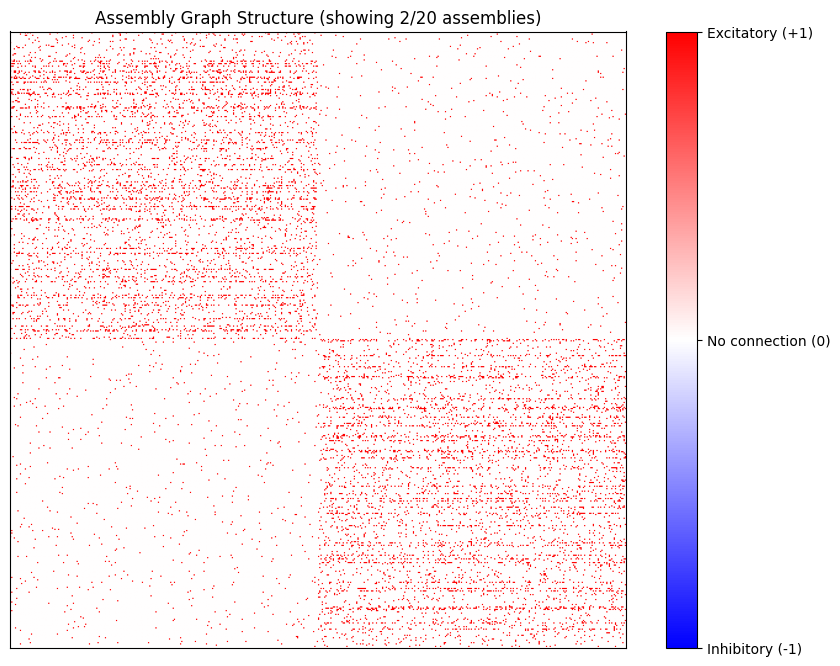

In [9]:
# | code-fold: true
# | code-summary: "Plot connectivity graph"
# Visualize assembly graph structure
plot_num_assemblies = 2  # Number of assemblies to display
neurons_per_assembly = num_neurons // num_assemblies
plot_size_neurons = neurons_per_assembly * plot_num_assemblies

# Fixed size in inches for the heatmap
heatmap_inches = 8  # Bigger fixed size
fig, ax = plt.subplots(
    figsize=(heatmap_inches * 1.3, heatmap_inches)
)  # Extra width for colorbar

im = ax.imshow(
    connectivity_graph[:plot_size_neurons, :plot_size_neurons],
    cmap="bwr",
    vmin=-1,
    vmax=1,
    aspect="equal",
)

# Force the axes to be square first
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.height, pos.height])

# Add colorbar after positioning
cbar = plt.colorbar(im, ax=ax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(["Inhibitory (-1)", "No connection (0)", "Excitatory (+1)"])

ax.set_title(
    f"Assembly Graph Structure (showing {plot_num_assemblies}/{num_assemblies} assemblies)"
)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

### Assign Synaptic Weights

We now convert the unweighted connectivity graph into a weighted graph, with inhibitory and excitatory synaptic strengths drawn from biologically realistic log-normal distributions.

We want to balance the total synaptic input to each neuron on average. Given that the log-normal distribution has expectation:

$$\mathbb{E}[X] = \exp\left(\mu + \frac{\sigma^2}{2}\right)$$

And we have roughly four times as many excitatory neurons as inhibitory neurons, we can approximately acheive balance by setting:

$$\mu_I = \mu_E + \log{4}$$

We then visualise this graph and check the distribution of input weights to all neurons is roughly balanced.

In [10]:
# | code-fold: true
# | code-summary: "Display weight parameters"
# Display recurrent synaptic weight parameters
print("Recurrent Synaptic Weight Parameters")
print("=" * 32)
print("\nLog-space means for synapse strengths (log-normal):")
for i, row in enumerate(w_mu):
    from_type = cell_type_names[i]
    for j, mean in enumerate(row):
        to_type = cell_type_names[j]
        print(f"  {from_type} → {to_type}: {mean}")

print("\nLog-space standard deviations for synapse strengths (log-normal):")
for i, row in enumerate(w_sigma):
    from_type = cell_type_names[i]
    for j, std in enumerate(row):
        to_type = cell_type_names[j]
        print(f"  {from_type} → {to_type}: {std}")

Recurrent Synaptic Weight Parameters

Log-space means for synapse strengths (log-normal):
  excitatory → excitatory: 1.0
  excitatory → inhibitory: 1.2
  inhibitory → excitatory: 2.4
  inhibitory → inhibitory: 1.6

Log-space standard deviations for synapse strengths (log-normal):
  excitatory → excitatory: 0.8
  excitatory → inhibitory: 0.8
  inhibitory → excitatory: 0.2
  inhibitory → inhibitory: 0.2


In [11]:
# Assign log-normal weights to connectivity graph
weights = weight_assigners.assign_weights_lognormal(
    connectivity_graph=connectivity_graph,
    source_cell_indices=cell_type_indices,
    target_cell_indices=cell_type_indices,  # Same for recurrent connections
    cell_type_signs=cell_type_signs,
    w_mu_matrix=w_mu,
    w_sigma_matrix=w_sigma,
)

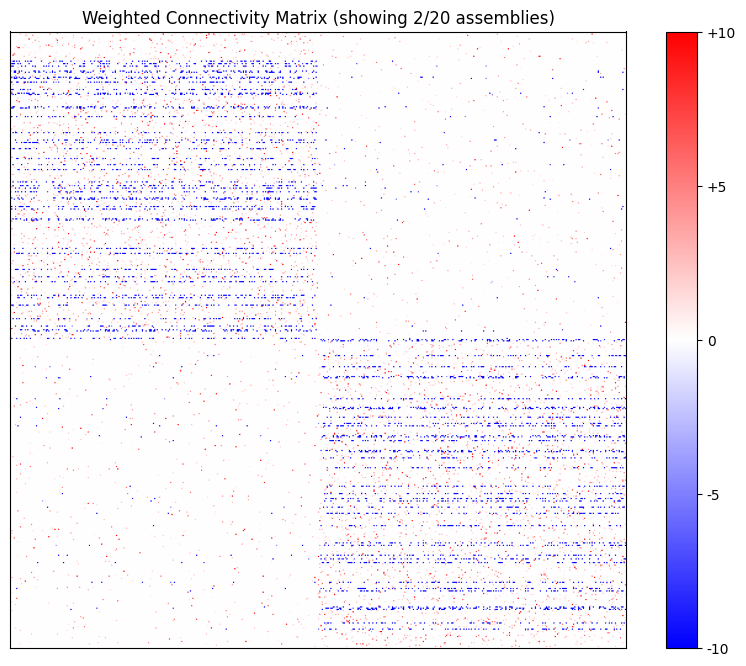

In [12]:
# | code-fold: true
# | code-summary: "Plot weighted connectivity matrix"
# Visualize weighted connectivity matrix
plot_num_assemblies = 2  # Number of assemblies to display
neurons_per_assembly = num_neurons // num_assemblies
plot_size_neurons = neurons_per_assembly * plot_num_assemblies

# Fixed size in inches for the heatmap (same as unweighted)
heatmap_inches = 8  # Bigger fixed size
fig, ax = plt.subplots(
    figsize=(heatmap_inches * 1.3, heatmap_inches)
)  # Extra width for colorbar

im = ax.imshow(
    weights[:plot_size_neurons, :plot_size_neurons],
    cmap="bwr",
    vmin=-10,
    vmax=10,
    aspect="equal",
)

# Force the axes to be square first
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.height, pos.height])

# Add colorbar after positioning
cbar = plt.colorbar(im, ax=ax, ticks=[-10, -5, 0, 5, 10])
cbar.ax.set_yticklabels(["-10", "-5", "0", "+5", "+10"])

ax.set_title(
    f"Weighted Connectivity Matrix (showing {plot_num_assemblies}/{num_assemblies} assemblies)"
)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

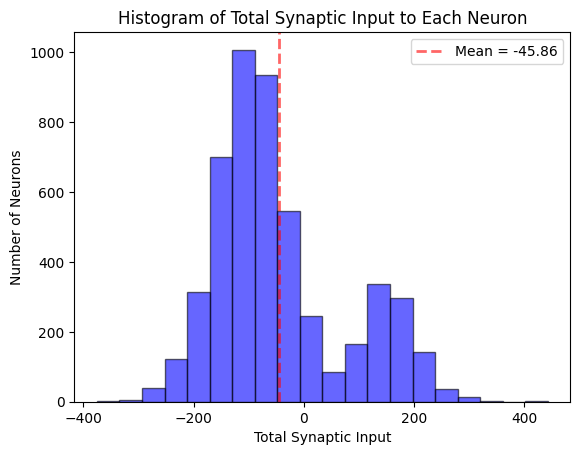

In [13]:
# | code-fold: true
# | code-summary: "Plot synaptic input distribution"
# Plot histogram of total synaptic input to each neuron
synaptic_inputs = weights.sum(axis=0)
mean_input = synaptic_inputs.mean()

fig, ax = plt.subplots()
ax.hist(
    synaptic_inputs, bins=20, color="#0000FF", edgecolor="black", alpha=0.6
)  # Blue from bwr colormap
ax.axvline(
    mean_input,
    color="#FF0000",
    linestyle="--",
    linewidth=2,
    alpha=0.6,
    label=f"Mean = {mean_input:.2f}",
)  # Red from bwr
ax.set_title("Histogram of Total Synaptic Input to Each Neuron")
ax.set_xlabel("Total Synaptic Input")
ax.set_ylabel("Number of Neurons")
ax.legend()
plt.show()

### Create network inputs

To run our network simulation, we additionally need to define feedforward inputs into the network.

To simulate baseline activity in the zebrafish olfactory bulb (OB), we simulate a population of mitral cells firing with Poisson statistics. These cells then project randomly with sparse connectivity to excitatory cells in our Dp network, with weights generated from a log-normal distribution.

In [14]:
# | code-fold: true
# | code-summary: "Display feedforward parameters"
# Display feedforward input parameters
print("Feedforward Input Parameters")
print("=" * 26)
print(f"Input neurons: {input_num_neurons}")
print(f"Input firing rates: {input_firing_rates} Hz")

print("\nConnection probabilities from inputs to connectome:")
for i, row in enumerate(input_conn_inputs):
    from_type = input_cell_type_names[i]
    for j, prob in enumerate(row):
        to_type = cell_type_names[j]
        print(f"  {from_type} → {to_type}: {prob}")

print("\nLog-space means for feedforward synapse strengths:")
for i, row in enumerate(input_w_mu):
    from_type = input_cell_type_names[i]
    for j, mean in enumerate(row):
        to_type = cell_type_names[j]
        print(f"  {from_type} → {to_type}: {mean}")

print("\nLog-space standard deviations for feedforward synapse strengths:")
for i, row in enumerate(input_w_sigma):
    from_type = input_cell_type_names[i]
    for j, std in enumerate(row):
        to_type = cell_type_names[j]
        print(f"  {from_type} → {to_type}: {std}")

Feedforward Input Parameters
Input neurons: 1500
Input firing rates: [6.] Hz

Connection probabilities from inputs to connectome:
  mitral → excitatory: 0.02
  mitral → inhibitory: 0.0

Log-space means for feedforward synapse strengths:
  mitral → excitatory: 1.0
  mitral → inhibitory: 0.0

Log-space standard deviations for feedforward synapse strengths:
  mitral → excitatory: 0.2
  mitral → inhibitory: 0.0


In [15]:
# Generate Poisson spike trains for mitral cells
n_steps = int(duration / dt)
shape = (1, n_steps, input_num_neurons)
p_spike = input_firing_rates[0] * dt * 1e-3  # rate in Hz, dt in ms
input_spikes = np.random.rand(*shape) < p_spike

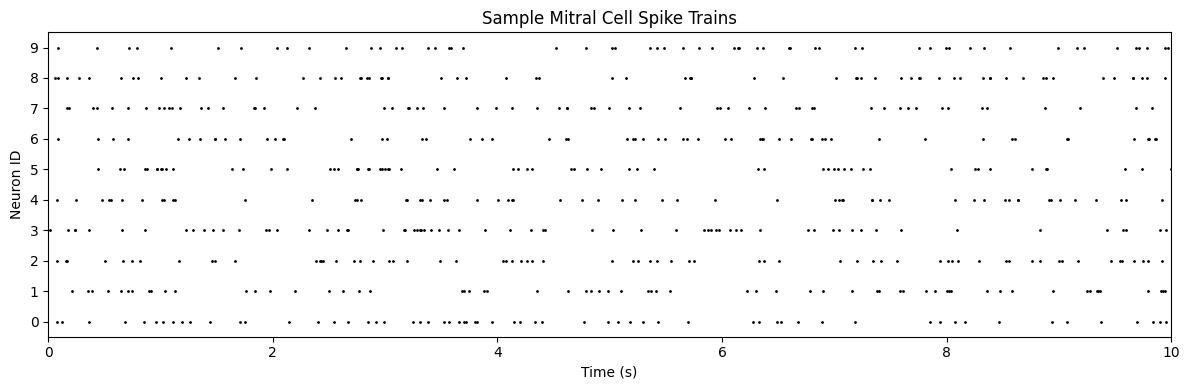

In [16]:
# | code-fold: true
# | code-summary: "Plot mitral cell spike trains"
# Visualize sample mitral cell spike trains
n_neurons_plot = 10
fraction = 1.0  # fraction of duration to plot
fig, ax = plt.subplots(figsize=(12, 4))
spike_times, neuron_ids = np.where(input_spikes[0, :, :n_neurons_plot])
ax.scatter(spike_times * dt * 1e-3, neuron_ids, s=1, color="black")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Neuron ID")
ax.set_title("Sample Mitral Cell Spike Trains")
ax.set_ylim(-0.5, n_neurons_plot - 0.5)
ax.set_yticks(range(n_neurons_plot))
ax.set_xlim(0, duration * 1e-3 * fraction)
plt.tight_layout()
plt.show()

In [17]:
# Assign cell types to input layer (all mitral cells are type 0)
input_source_indices = cell_types.assign_cell_types(
    num_neurons=input_num_neurons,
    cell_type_proportions=[1.0],  # Input layer: all mitral cells
)

# Generate feedforward connectivity graph
feedforward_connectivity_graph = topology_generators.sparse_graph_generator(
    source_cell_types=input_source_indices,
    target_cell_types=cell_type_indices,  # Connectome layer cell assignments
    conn_matrix=input_conn_inputs,  # Connection probability matrix
    allow_self_loops=True,  # Allow for feedforward connections
)

In [18]:
# Assign log-normal weights to feedforward connectivity
feedforward_weights = weight_assigners.assign_weights_lognormal(
    connectivity_graph=feedforward_connectivity_graph,
    source_cell_indices=input_source_indices,
    target_cell_indices=cell_type_indices,
    cell_type_signs=[1],  # Input mitral cells are excitatory (sign +1)
    w_mu_matrix=input_w_mu,
    w_sigma_matrix=input_w_sigma,
)

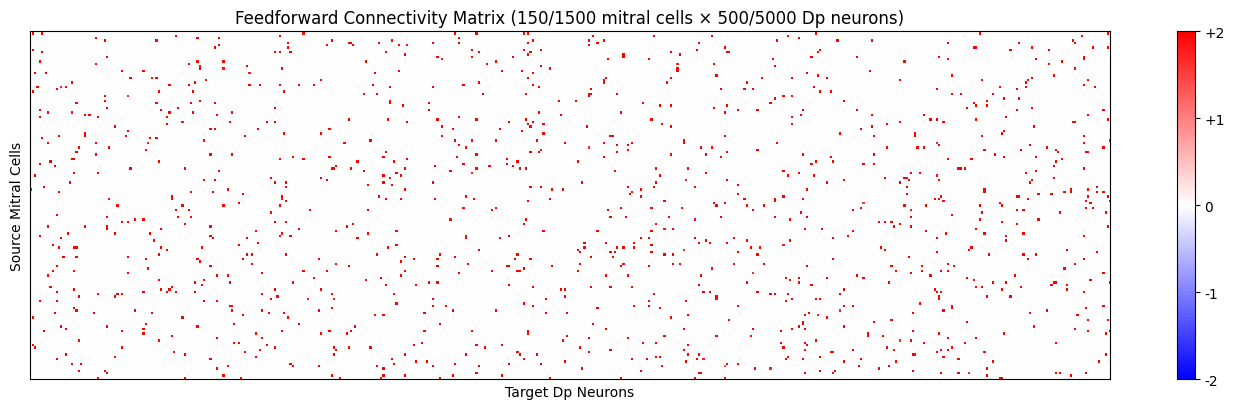

In [19]:
# | code-fold: true
# | code-summary: "Plot feedforward connectivity matrix"
# Visualize feedforward connectivity matrix
plot_fraction = 0.1  # Fraction of neurons to display
n_input, n_output = feedforward_weights.shape
n_input_plot = int(n_input * plot_fraction)
n_output_plot = int(n_output * plot_fraction)

# Make plot bigger - use fixed large size
plot_width = 14
plot_height = plot_width * n_input_plot / n_output_plot

fig, ax = plt.subplots(figsize=(plot_width, plot_height))
im = ax.imshow(
    feedforward_weights[:n_input_plot, :n_output_plot],
    cmap="bwr",
    vmin=-2,
    vmax=2,
    aspect="auto",
    interpolation="nearest",
)
cbar = plt.colorbar(im, ax=ax, ticks=[-2, -1, 0, 1, 2])
cbar.ax.set_yticklabels(["-2", "-1", "0", "+1", "+2"])
ax.set_title(
    f"Feedforward Connectivity Matrix ({n_input_plot}/{n_input} mitral cells × {n_output_plot}/{n_output} Dp neurons)"
)
ax.set_xlabel("Target Dp Neurons")
ax.set_ylabel("Source Mitral Cells")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

### Neuron Physiology Parameters

Before we can simulate a recurrent SNN with this weight matrix, we review the neuron physiology parameters.

These parameters are adapted from [Meissner-Bernard et al. (2025)](https://doi.org/10.1016/j.celrep.2025.115330), which includes a combination of parameters measured in zebrafish Dp and some fit to match experimental network activity recordings in this network.

In [20]:
# | code-fold: true
# | code-summary: "Display physiology parameters"
# Display neuron physiology parameters for each cell type
print("Neuron Physiology Parameters (adapted from Meissner-Bernard et al. 2025)")
print("=" * 62)

for cell_type, params_dict in physiology_params.items():
    print(f"\n{cell_type.capitalize()} Neurons:")
    for param, value in params_dict.items():
        print(f"  {param}: {value}")

# Display input physiology parameters
print("\nInput Physiology Parameters:")
for cell_type, params_dict in physiology_params_FF.items():
    print(f"\n{cell_type.capitalize()} Input Neurons:")
    for param, value in params_dict.items():
        print(f"  {param}: {value}")

Neuron Physiology Parameters (adapted from Meissner-Bernard et al. 2025)

Excitatory Neurons:
  tau_mem: 85.0
  tau_syn: 30.0
  R: 740.74
  U_rest: -60.0
  theta: -38.0
  U_reset: -60.0

Inhibitory Neurons:
  tau_mem: 50.0
  tau_syn: 10.0
  R: 1111.11
  U_rest: -60.0
  theta: -45.0
  U_reset: -60.0

Input Physiology Parameters:

Mitral Input Neurons:
  tau_syn: 30.0


### Neuron input considerations

Prior to running our simulation, we briefly calculate the mean synaptic input to each neuron in the recurrent network from the three possible cell types. This should give an indication of the type of dynamical regime we expect the network to be in.

In [21]:
# | code-fold: true
# | code-summary: "Calculate and display mean inputs"
# Calculate expected connection probabilities
p_recurrent = {}
for i, type_name in enumerate(cell_type_names):
    # Average connection probability considering assembly structure
    p_recurrent[type_name] = (1 / num_assemblies) * np.mean(conn_within[i]) + (
        1 - 1 / num_assemblies
    ) * np.mean(conn_between[i])

# Calculate expected weights
expected_weights = {}
for i, source_type in enumerate(cell_type_names):
    for j, target_type in enumerate(cell_type_names):
        # Mean of log-normal distribution: exp(mu + sigma^2/2)
        expected_weights[f"{source_type}→{target_type}"] = np.exp(
            w_mu[i][j] + w_sigma[i][j] ** 2 / 2
        )

# Calculate expected input weights
expected_ff_weights = {}
for i, source_type in enumerate(input_cell_type_names):
    for j, target_type in enumerate(cell_type_names):
        # Mean of log-normal distribution: exp(mu + sigma^2/2)
        expected_ff_weights[f"{source_type}→{target_type}"] = np.exp(
            input_w_mu[i][j] + input_w_sigma[i][j] ** 2 / 2
        )

# Display mean synaptic inputs (simplified calculation for clarity)
print("Expected Connection Probabilities")
print("=" * 30)
for type_name, prob in p_recurrent.items():
    print(f"{type_name}: {prob:.4f}")

print("\nExpected Weights (before scaling)")
print("=" * 30)
for connection, weight in expected_weights.items():
    print(f"{connection}: {weight:.4f}")

print("\nExpected Feedforward Weights (before scaling)")
print("=" * 40)
for connection, weight in expected_ff_weights.items():
    print(f"{connection}: {weight:.4f}")

print("\nScaling Factors")
print("=" * 15)
print(f"Recurrent scaling factors:\n{scaling_factors}")
print(f"Feedforward scaling factors:\n{scaling_factors_FF}")

Expected Connection Probabilities
excitatory: 0.0120
inhibitory: 0.0182

Expected Weights (before scaling)
excitatory→excitatory: 3.7434
excitatory→inhibitory: 4.5722
inhibitory→excitatory: 11.2459
inhibitory→inhibitory: 5.0531

Expected Feedforward Weights (before scaling)
mitral→excitatory: 2.7732
mitral→inhibitory: 1.0000

Scaling Factors
Recurrent scaling factors:
[[0.003 0.003]
 [0.004 0.004]]
Feedforward scaling factors:
[[0.004 0.004]]


### Initialise network and run simulation

Here we finally initialise our current-based LIF recurrent network with the connectivity and inputs we have created. We run our simulation and plot some sample output spiketrains and statistics from the model.

In [22]:
# Initialize LIF network model with corrected arguments
model = CurrentLIFNetwork(
    weights=weights,
    cell_types=cell_type_names,
    cell_type_indices=cell_type_indices,
    physiology_params=physiology_params,
    scaling_factors=scaling_factors,
    surrgrad_scale=surrgrad_scale,
    weights_FF=feedforward_weights,
    cell_types_FF=input_cell_type_names,
    cell_type_indices_FF=input_source_indices,
    physiology_params_FF=physiology_params_FF,
    scaling_factors_FF=scaling_factors_FF,
)

# Move model to device for GPU acceleration
model.to(device)

# Run inference
with torch.inference_mode():
    output_spikes, output_voltages, output_I, output_I_FF = model.forward(
        n_steps=n_steps,
        dt=dt,
        inputs=input_spikes,
    )

# Move tensors to CPU for further processing and visualization
output_spikes = output_spikes.cpu()
output_voltages = output_voltages.cpu()
output_I = output_I.cpu()
output_I_FF = output_I_FF.cpu()

Simulating network: 100%|██████████| 10000/10000 [01:16<00:00, 130.65step/s]



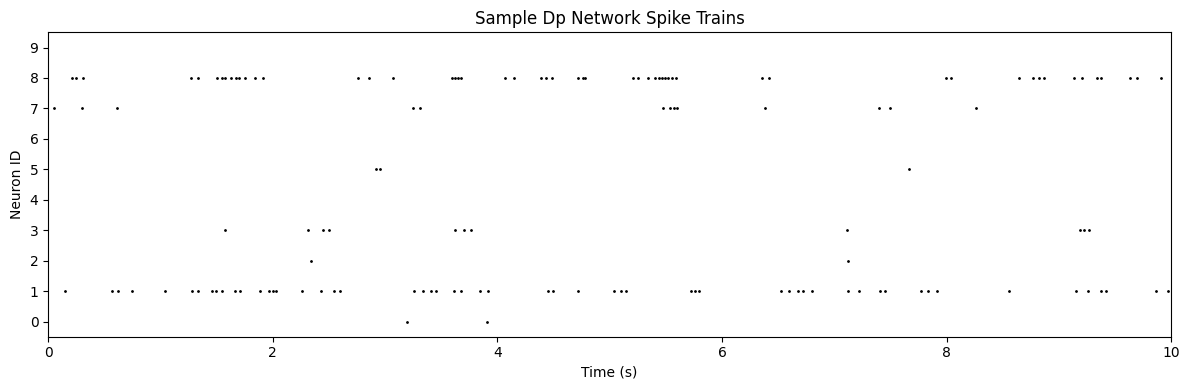

In [23]:
# | code-fold: true
# | code-summary: "Plot network spike trains"
# Visualize Dp network spike trains
n_neurons_plot = 10
fraction = 1.0  # fraction of duration to plot
fig, ax = plt.subplots(figsize=(12, 4))
spike_times, neuron_ids = np.where(output_spikes[0, :, :n_neurons_plot].numpy())
ax.scatter(spike_times * dt * 1e-3, neuron_ids, s=1, color="black")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Neuron ID")
ax.set_title("Sample Dp Network Spike Trains")
ax.set_ylim(-0.5, n_neurons_plot - 0.5)
ax.set_yticks(range(n_neurons_plot))
ax.set_xlim(0, duration * 1e-3 * fraction)
plt.tight_layout()
plt.show()

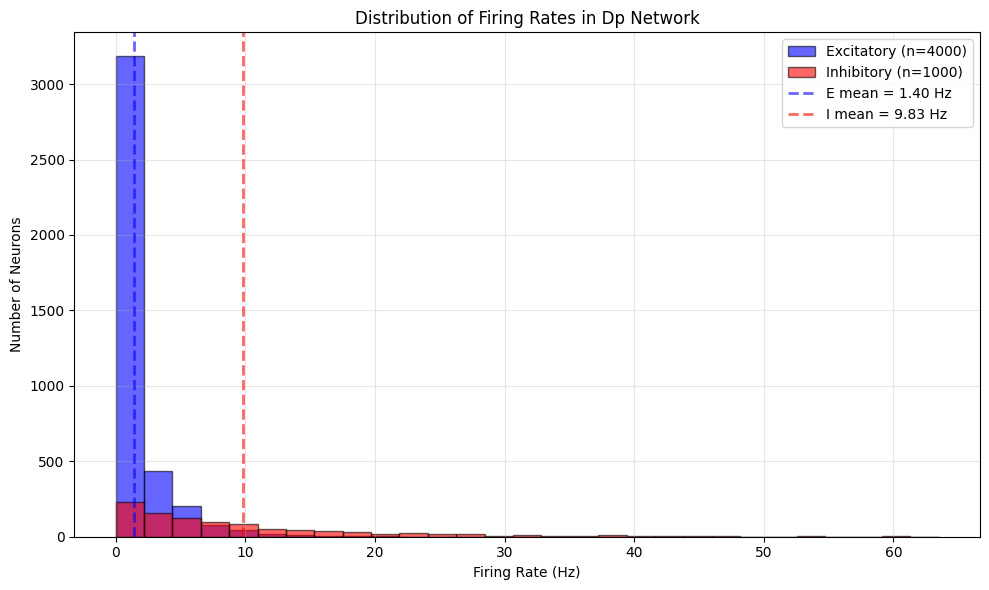

Excitatory neurons: mean = 1.40 Hz, std = 2.46 Hz
Inhibitory neurons: mean = 9.83 Hz, std = 10.48 Hz


In [24]:
# | code-fold: true
# | code-summary: "Plot firing rate distribution"
# Compute and plot firing rates for all neurons
# Calculate firing rates (spikes per second)
spike_counts = output_spikes[0].sum(axis=0).numpy()  # Total spikes per neuron
firing_rates = spike_counts / (duration * 1e-3)  # Convert duration from ms to s

# Separate firing rates by neuron type
excitatory_rates = firing_rates[neuron_types == 1]
inhibitory_rates = firing_rates[neuron_types == -1]

# Create histogram with bwr colormap colors
fig, ax = plt.subplots(figsize=(10, 6))
bins = np.linspace(0, max(firing_rates.max(), 1), 30)

ax.hist(
    excitatory_rates,
    bins=bins,
    alpha=0.6,
    color="#0000FF",
    label=f"Excitatory (n={len(excitatory_rates)})",
    edgecolor="black",
)  # Blue from bwr
ax.hist(
    inhibitory_rates,
    bins=bins,
    alpha=0.6,
    color="#FF0000",
    label=f"Inhibitory (n={len(inhibitory_rates)})",
    edgecolor="black",
)  # Red from bwr

# Add mean lines
ax.axvline(
    excitatory_rates.mean(),
    alpha=0.6,
    color="#0000FF",
    linestyle="--",
    linewidth=2,
    label=f"E mean = {excitatory_rates.mean():.2f} Hz",
)
ax.axvline(
    inhibitory_rates.mean(),
    alpha=0.6,
    color="#FF0000",
    linestyle="--",
    linewidth=2,
    label=f"I mean = {inhibitory_rates.mean():.2f} Hz",
)

ax.set_xlabel("Firing Rate (Hz)")
ax.set_ylabel("Number of Neurons")
ax.set_title("Distribution of Firing Rates in Dp Network")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(
    f"Excitatory neurons: mean = {excitatory_rates.mean():.2f} Hz, std = {excitatory_rates.std():.2f} Hz"
)
print(
    f"Inhibitory neurons: mean = {inhibitory_rates.mean():.2f} Hz, std = {inhibitory_rates.std():.2f} Hz"
)

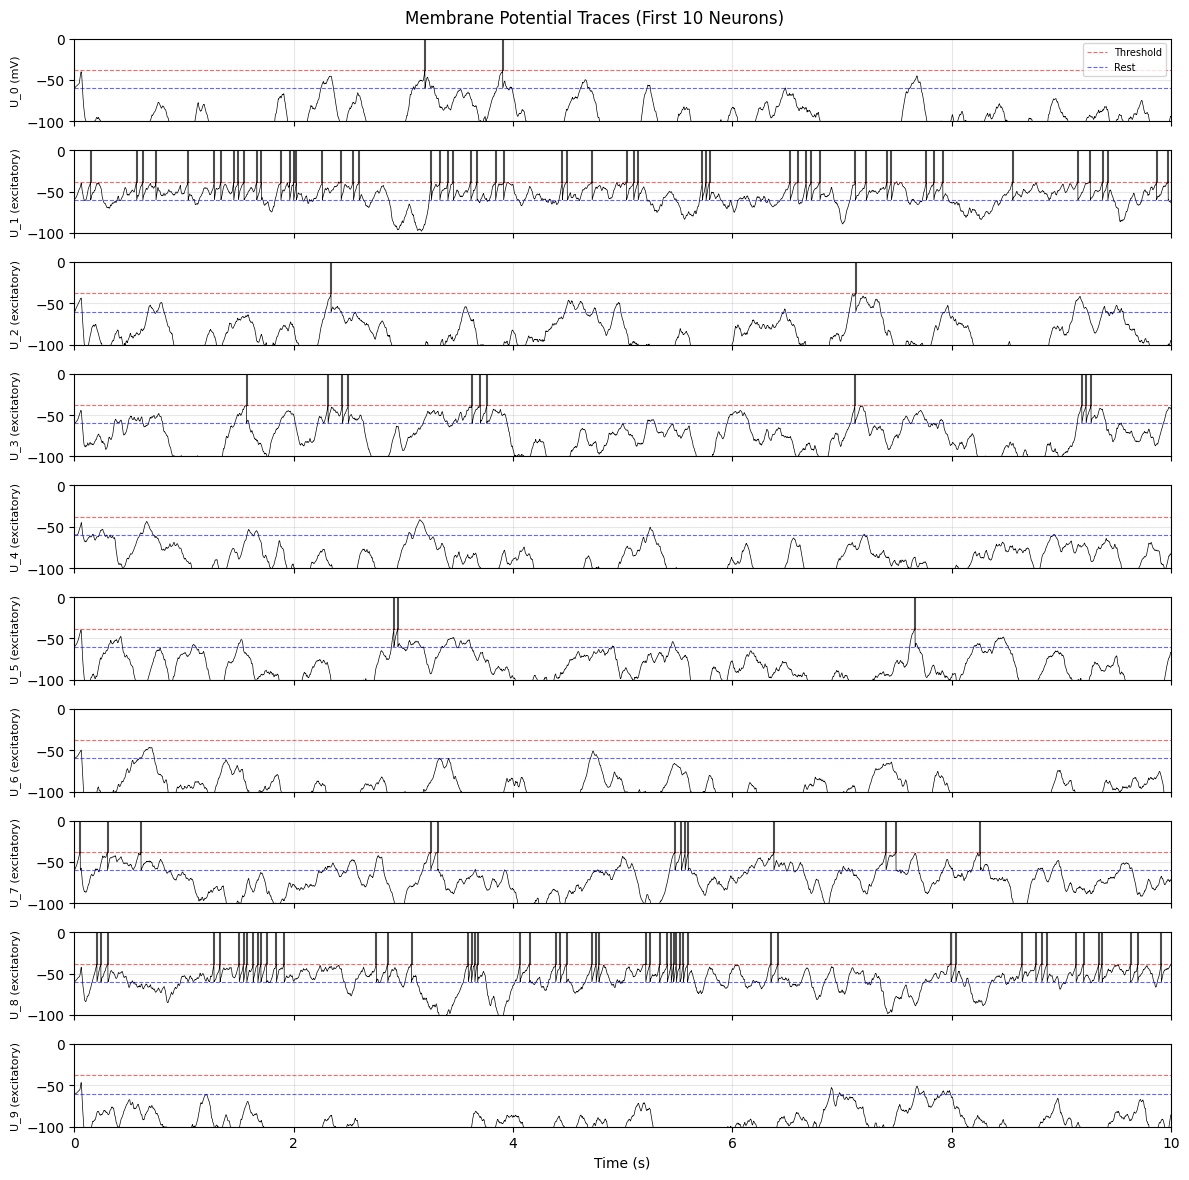

In [25]:
# | code-fold: true
# | code-summary: "Plot membrane voltage traces"
# Create neuron_params dictionary for visualization
neuron_params = {}
for i, name in enumerate(cell_type_names):
    sign = cell_type_signs[i]
    neuron_params[i] = {  # Use integer keys to match cell_type_idx
        "tau_mem": physiology_params[name]["tau_mem"],
        "tau_syn": physiology_params[name]["tau_syn"],
        "R": physiology_params[name]["R"],
        "rest": physiology_params[name][
            "U_rest"
        ],  # Updated to match visualization function
        "threshold": physiology_params[name][
            "theta"
        ],  # Updated to match visualization function
        "reset": physiology_params[name][
            "U_reset"
        ],  # Updated to match visualization function
        "name": name,
        "sign": sign,
    }

# Visualize membrane voltages for the first 10 neurons
plot_membrane_voltages(
    voltages=output_voltages,
    spikes=output_spikes,
    neuron_types=cell_type_indices,
    neuron_params=neuron_params,
    delta_t=dt,
    duration=duration,
    n_neurons_plot=10,
    fraction=1,
    y_min=-100,
    y_max=0,
    y_tick_step=50,
)

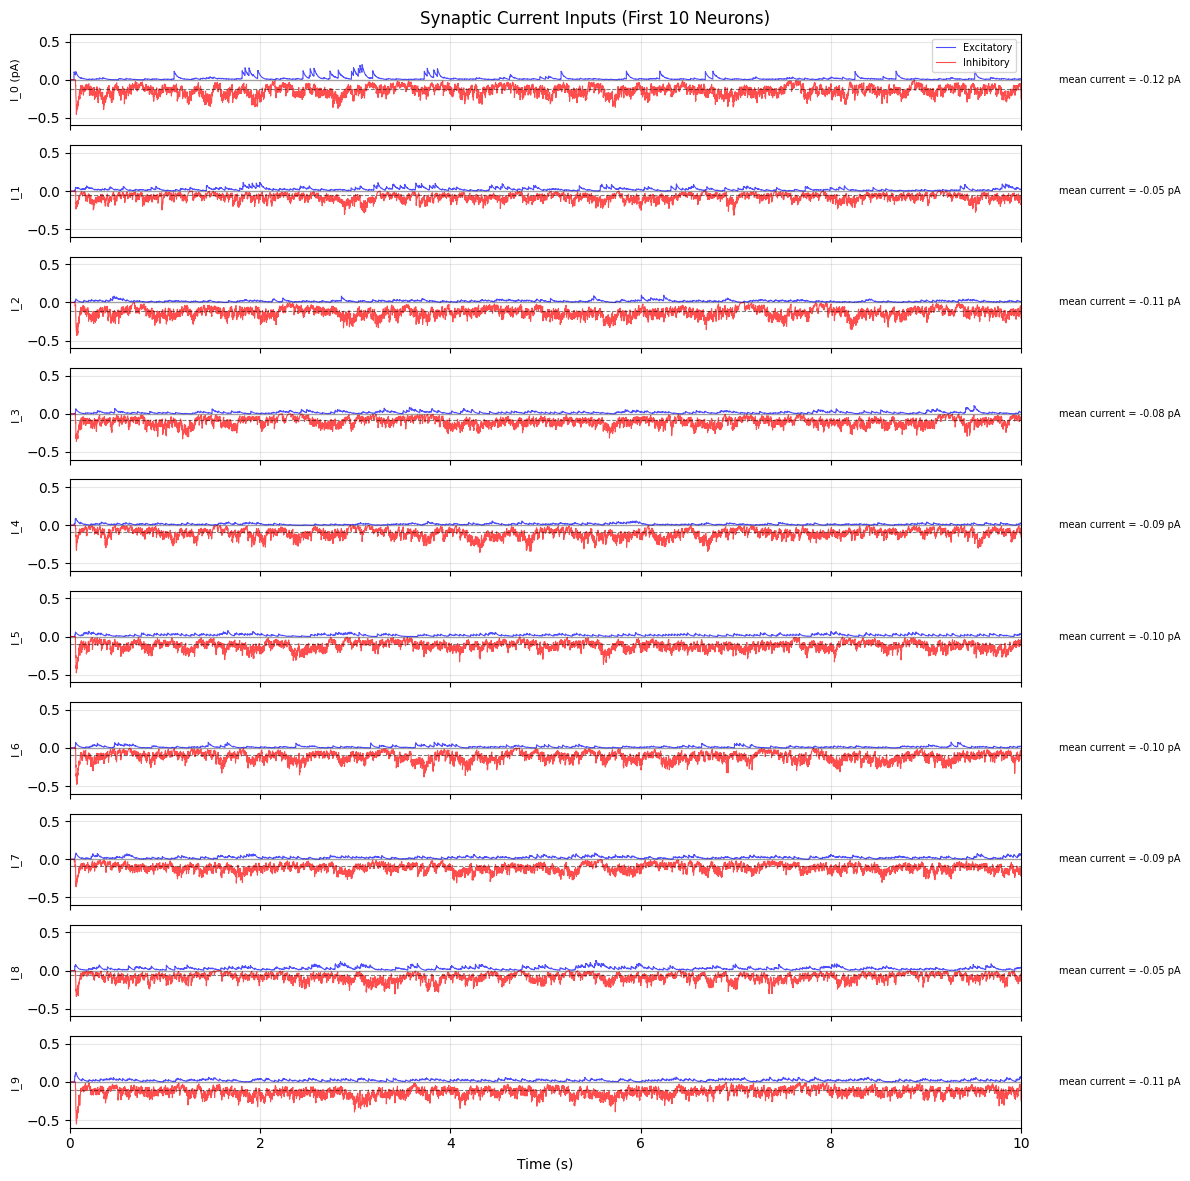

In [26]:
# | code-fold: true
# | code-summary: "Plot synaptic currents by source"
# Visualize synaptic currents for the first 10 neurons
plot_synaptic_currents(
    I_exc=output_I[..., 0],  # Slice for excitatory currents
    I_inh=output_I[..., 1],  # Slice for inhibitory currents
    delta_t=dt,
    duration=duration,
    n_neurons_plot=10,
    fraction=1,
)